In [120]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *
from code.fc import *
from code.fc_cluster import *
from collections import Counter,defaultdict,OrderedDict

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
import cPickle as pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Feature Contribution Analysis

In this session, how does each feature contribute to random forest decision making will be analysed. 
## 1. Load feature contribution matrix and group by cluster id

In [4]:
fc = FeatureContribution('data/fc_df2.pkl')
fc_df = fc.cluster_processor(3,6)

In [5]:
summary = fc_df.groupby('cluster')['employed'].agg([np.mean,np.size])
summary.columns = ['employment_rate','sample_size']
summary

,employment_rate,sample_size
cluster,,
0,0.924484,2132
1,0.082192,365
2,0.040498,642
3,0.900459,653
4,0.895753,259
5,0.059809,418


**Cluster 1,2,5** are unemployed groups. **Cluster 0,3,4** are employed groups. 


## 2.  Load original survey data

In [6]:
sv = survey('data/survey2')
sv.num_processor()

In [8]:
df = pd.concat([sv.fin_data[sv.num_cols],sv.data[sv.sv_cols],sv.fin_data.employed],axis =1)

f40 = fc_df.columns[:41]
df40= df[f40]
l = list(df40.columns)
l.append('cluster')

new = np.column_stack((df31.values,fc_df.cluster))
df = pd.DataFrame(new,columns=l)

### Group by cluster. Take medians for numeric variables. Take mode for categorical variables.

In [9]:
df[sv.num_cols] = df[sv.num_cols].astype('float')

In [10]:
df_num = df.groupby('cluster')[sv.num_cols].agg([np.median])

In [11]:
df_num

,sphrs1,age,agekdbrn,chldidel,coninc,educom
,median,median,median,median,median,median
cluster,,,,,,
0,60.0,36,25,4.0,49882.50,12.333333
1,98.0,31,19,5.0,8617.50,12.000000
2,54.5,35,25,8.0,52811.00,12.666667
3,98.0,33,21,4.0,9033.75,12.333333
4,98.0,34,19,4.0,18745.00,11.666667
5,98.0,34,22,6.5,7124.00,12.333333


BS ratio: 0.50123070038
BS number: 2240


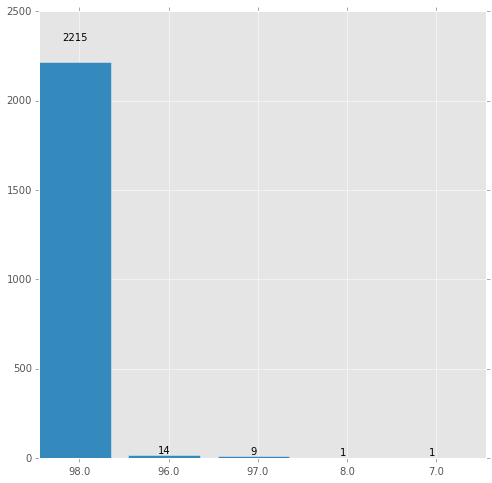

In [116]:
check_bs(df.sphrs1,sv.bs_flag)

BS ratio: 0.479973148355
BS number: 2145


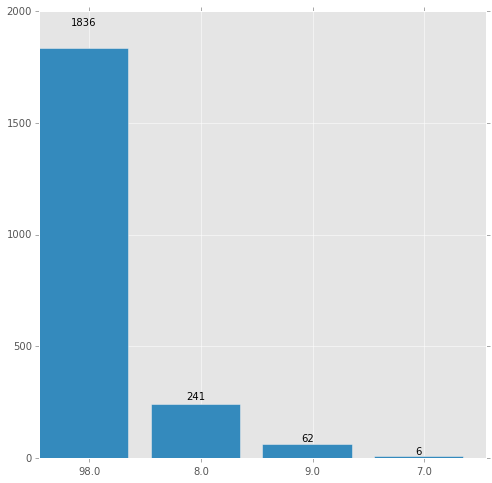

In [119]:
check_bs(df.chldidel,sv.bs_flag)

About half respondents did not answer spouse working hours or ideal number of kids. It's not accurate to take mean or median without removing the flag. Thereby, I'll remove respondents who didn't answer these two questions, then take mean values. 

Age and agekdbrn maintain the median value

In [145]:
df_num['chldidel'] = df.groupby('cluster')['chldidel'].apply(lambda x: flag_rm_mean(x,[98,9]))

In [146]:
df_num['']

,sphrs1,age,agekdbrn,chldidel,coninc,educom
,median,median,median,median,median,median
cluster,,,,,,
0,60.0,36,25,2.88,49882.50,12.333333
1,98.0,31,19,3.34,8617.50,12.000000
2,54.5,35,25,3.30,52811.00,12.666667
3,98.0,33,21,3.05,9033.75,12.333333
4,98.0,34,19,2.98,18745.00,11.666667
5,98.0,34,22,3.19,7124.00,12.333333


In [11]:
cat_cols = list(set(df.columns) - set(sv.num_cols) - set(['cluster']))

In [12]:
df_cat = df.groupby('cluster')[cat_cols].agg([mode_answer,percent])

In [13]:
df_summary = pd.concat([df_num,df_cat],axis =1)

In [122]:
df_summary.T

cluster                                  0                     1  \
sphrs1   median             Not applicable                    51   
age      median                         34                    35   
agekdbrn median                         22                    25   
chldidel median                        4.5       As many as want   
coninc   median                     6633.5                 51705   
educom   median                    12.3333               12.6667   
fechld   mode_answer        Not applicable        Not applicable   
         percent                      0.37                  0.43   
natrace  mode_answer        Not applicable        Not applicable   
         percent                      0.54                  0.54   
socfrend mode_answer        Not applicable        Not applicable   
         percent                      0.39                  0.44   
reliten  mode_answer       Not very strong                Strong   
         percent                      0.41                  0.45   
res16    mode_answer         Town lt 50000         Town lt 50000   
         percent                      0.32                  0.29   
divorce  mode_answer        Not applicable                    No   
         percent                      0.62                  0.73   
polviews mode_answer              Moderate              Moderate   
         percent                      0.36                  0.34   
fefam    mode_answer        Not applicable        Not applicable   
         percent                      0.37                  0.43   
socbar   mode_answer        Not applicable        Not applicable   
         percent                      0.39                  0.44   
partyid  mode_answer           Independent      Not str democrat   
         percent                      0.29                  0.19   
employed mode_answer                 False                 False   
         percent                      0.93                  0.94   
finrela  mode_answer         Below average               Average   
         percent                      0.33                  0.41   
meovrwrk mode_answer        Not applicable        Not applicable   
         percent                       0.5                  0.53   
helpoth  mode_answer        Not applicable        Not applicable   
         percent                      0.47                  0.46   
degree   mode_answer           High school           High school   
         percent                      0.82                  0.58   
class_   mode_answer         Working class          Middle class   
         percent                       0.4                  0.47   
courts   mode_answer      Not harsh enough      Not harsh enough   
         percent                      0.55                  0.57   
workhard mode_answer        Not applicable        Not applicable   
         percent                      0.47                  0.46   
incom16  mode_answer        Not applicable        Not applicable   
         percent                      0.47                  0.49   
dwelling mode_answer  Detached 1-fam house  Detached 1-fam house   
         percent                      0.44                  0.72   
natsoc   mode_answer            Too little            Too little   
         percent                      0.52                  0.53   
fund     mode_answer        Fundamentalist              Moderate   
         percent                      0.37                  0.43   
natroad  mode_answer           About right           About right   
         percent                      0.41                  0.52   
parsol   mode_answer        Not applicable        Not applicable   
         percent                      0.46                  0.45   
mawrkgrw mode_answer                   Yes                   Yes   
         percent                      0.61                  0.64   

cluster                                  2                     3  \
sphrs1   median                         60        Not a

## 3. Unemployed Clusters

### Cluster 0

In [14]:
c0 = fc_df[fc_df.cluster == 0]

These features are the top 10 features driving the decision.

In [15]:
sort_feature_means(c0,10)

[(-0.10317363862869754, 'coninc'),
 (-0.03392890421279629, 'age'),
 (-0.027697984375685748, 'class_'),
 (-0.023296867668049392, 'agekdbrn'),
 (-0.019737805836251204, 'polviews'),
 (-0.019515172650691602, 'educom'),
 (0.018331218255143, 'degree'),
 (-0.01765954711605959, 'finrela'),
 (-0.016752126734590513, 'partyid'),
 (-0.014696917162165184, 'dwelling')]

#### Details in their answers

In [16]:
df_c0 = df[df.cluster ==0]

In [17]:
df_summary.ix[0][:6]

sphrs1    median    Not applicable
age       median                34
agekdbrn  median                22
chldidel  median               4.5
coninc    median            6633.5
educom    median           12.3333
Name: 0, dtype: object

In [18]:
cluster_summary(df_c0,cat_cols)

,rank_first,rank_second
fechld,"(Not applicable, 0.37)","(Agree, 0.3)"
natrace,"(Not applicable, 0.54)","(Too little, 0.19)"
socfrend,"(Not applicable, 0.39)","(Sev times a week, 0.14)"
reliten,"(Not very strong, 0.41)","(Strong, 0.32)"
res16,"(Town lt 50000, 0.32)","(50000 to 250000, 0.18)"
divorce,"(Not applicable, 0.62)","(No, 0.31)"
polviews,"(Moderate, 0.36)","(Slghtly conservative, 0.12)"
fefam,"(Not applicable, 0.37)","(Disagree, 0.29)"
socbar,"(Not applicable, 0.39)","(Never, 0.33)"
partyid,"(Independent, 0.29)","(Not str democrat, 0.21)"


## Women in cluster 0 have following characteristics:
  * They are from poor family. Their median family income are below that in population median.
  * They consider themselves are in working class or lower class. They think their family income is below average. 
  * They and their family don't have higher education. About high school degree. 
  * They are fundamentalist. 
  * Their political views are moderate or slightly conservative.

### Cluster 1

In [19]:
c1 = fc_df[fc_df.cluster ==1]

Top 10 driving features

In [20]:
sort_feature_means(c1,10)

[(-0.037288764073244045, 'age'),
 (-0.035791882617825718, 'educom'),
 (-0.03210500848705275, 'sphrs1'),
 (-0.024466323673248431, 'agekdbrn'),
 (-0.021262571466462623, 'divorce'),
 (-0.019488294487885846, 'partyid'),
 (-0.016983742743410898, 'polviews'),
 (-0.016794016402045482, 'res16'),
 (-0.016444082678220302, 'incom16'),
 (-0.013788524842692908, 'reliten')]

In [21]:
df_c1 = df[df.cluster ==1]

In [22]:
df_summary.ix[1][:6]

sphrs1    median                 51
age       median                 35
agekdbrn  median                 25
chldidel  median    As many as want
coninc    median              51705
educom    median            12.6667
Name: 1, dtype: object

In [23]:
cluster_summary(df_c1,cat_cols)

,rank_first,rank_second
fechld,"(Not applicable, 0.43)","(Agree, 0.25)"
natrace,"(Not applicable, 0.54)","(About right, 0.2)"
socfrend,"(Not applicable, 0.44)","(Once a month, 0.14)"
reliten,"(Strong, 0.45)","(Not very strong, 0.31)"
res16,"(Town lt 50000, 0.29)","(50000 to 250000, 0.21)"
divorce,"(No, 0.73)","(Not applicable, 0.14)"
polviews,"(Moderate, 0.34)","(Conservative, 0.14)"
fefam,"(Not applicable, 0.43)","(Disagree, 0.25)"
socbar,"(Not applicable, 0.44)","(Never, 0.29)"
partyid,"(Not str democrat, 0.19)","(Not str republican, 0.18)"


### Women in cluster 1 have flowing characteristics:
  * Their husbands work full time.
  * Their median family incomes are higher than population.
  * They consider they are in middle class
  * They have high shool or college degrees
  * They are religious and moderate to conservatve political views
  * Their ideal number of children is as many as possible
  * Majority of them live in a house

## Cluster 3

In [24]:
c3 = fc_df[fc_df.cluster ==3]

In [25]:
sort_feature_means(c3,10)

[(-0.12603459366189285, 'degree'),
 (-0.070144543585678884, 'coninc'),
 (-0.023950349809438023, 'age'),
 (-0.019658434958345537, 'agekdbrn'),
 (-0.018318692565157935, 'educom'),
 (-0.014832189604645, 'class_'),
 (-0.012873632435843718, 'polviews'),
 (-0.01259424547771343, 'incom16'),
 (-0.011545633902283959, 'dwelling'),
 (-0.01122178542760326, 'socfrend')]

In [26]:
df_c3 = df[df.cluster ==3]

In [27]:
df_summary.ix[3][:6]

sphrs1    median    Not applicable
age       median                31
agekdbrn  median                19
chldidel  median                 5
coninc    median           8313.75
educom    median                12
Name: 3, dtype: object

In [28]:
cluster_summary(df_c3,cat_cols)

,rank_first,rank_second
fechld,"(Not applicable, 0.41)","(Agree, 0.23)"
natrace,"(Not applicable, 0.54)","(Too little, 0.17)"
socfrend,"(Not applicable, 0.42)","(Never, 0.15)"
reliten,"(Not very strong, 0.42)","(Strong, 0.26)"
res16,"(Town lt 50000, 0.34)","(City gt 250000, 0.21)"
divorce,"(Not applicable, 0.62)","(No, 0.3)"
polviews,"(Moderate, 0.35)","(Don't know, 0.13)"
fefam,"(Not applicable, 0.41)","(Disagree, 0.21)"
socbar,"(Not applicable, 0.42)","(Never, 0.38)"
partyid,"(Independent, 0.39)","(Not str democrat, 0.16)"


### Women in cluster 3 have flowing characteristics:
  * They don't have high degree. 99% of them have less than high school degree. 
  * Their median age of giving birth to their first child is 19, way lower than the entire population (23)
  * They are not religous and have moderate political views
  * They are either from small towns or from big cities
  * Their median family income is below population median and they consider their finanicial situations are below average.
  * Interestingly, 56% of the women in this cluster respond 'yes' to the question "Mothers employment when r was 16". 10% lower than the entire population.

## 4. Employed Class

### Cluster 2

In [29]:
c2 = fc_df[fc_df.cluster ==2]

In [30]:
sort_feature_means(c2,10)

[(0.045328848585600608, 'coninc'),
 (0.02123034015335842, 'degree'),
 (0.015127970950966903, 'age'),
 (0.011355628720333138, 'educom'),
 (0.010236085512343585, 'agekdbrn'),
 (0.0080189575014816203, 'sphrs1'),
 (0.0074831555803240154, 'polviews'),
 (0.0069228323390354389, 'partyid'),
 (0.0067388232864081842, 'class_'),
 (0.0065550122755228708, 'finrela')]

In [31]:
df_c2 = df[df.cluster==2]

In [32]:
df_summary.ix[2][:6]

sphrs1    median         60
age       median         36
agekdbrn  median         25
chldidel  median          4
coninc    median    49882.5
educom    median    12.3333
Name: 2, dtype: object

In [33]:
cluster_summary(df_c2,cat_cols)

,rank_first,rank_second
fechld,"(Not applicable, 0.39)","(Strongly agree, 0.25)"
natrace,"(Not applicable, 0.53)","(About right, 0.17)"
socfrend,"(Not applicable, 0.4)","(Once a month, 0.17)"
reliten,"(Not very strong, 0.38)","(Strong, 0.37)"
res16,"(Town lt 50000, 0.28)","(50000 to 250000, 0.21)"
divorce,"(No, 0.52)","(Not applicable, 0.33)"
polviews,"(Moderate, 0.36)","(Slghtly conservative, 0.13)"
fefam,"(Not applicable, 0.39)","(Disagree, 0.3)"
socbar,"(Not applicable, 0.4)","(Never, 0.23)"
partyid,"(Not str democrat, 0.22)","(Independent, 0.18)"


## Women in cluster 2 have the following characteratics:

  * Their husbands work full time. 
  * Median family incomes are about the population median
  * They have high degrees (at least high school)
  * They don't have strong affiliation to religions.
  * Their median age of having first children is later than the population. 
  * They consider themselves working or middle class

## Cluster 4

In [38]:
c4 = fc_df[fc_df.cluster ==4]

In [39]:
sort_feature_means(c4,10)

[(-0.046555906341039413, 'coninc'),
 (0.031598383557659884, 'degree'),
 (0.014469135696382071, 'age'),
 (0.013723895470837433, 'educom'),
 (0.011948090729284537, 'agekdbrn'),
 (0.01071230571848787, 'divorce'),
 (0.0097911880638121233, 'partyid'),
 (0.0085700286430870371, 'polviews'),
 (0.0083710358978435762, 'sphrs1'),
 (0.008002701860419523, 'dwelling')]

In [40]:
df_c4 = df[df.cluster==4]

In [42]:
df_summary.ix[4][:6]

sphrs1    median    Not applicable
age       median                33
agekdbrn  median                22
chldidel  median                 4
coninc    median           9486.56
educom    median           12.3333
Name: 4, dtype: object

In [43]:
cluster_summary(df_c4,cat_cols)

,rank_first,rank_second
fechld,"(Not applicable, 0.38)","(Agree, 0.25)"
natrace,"(Not applicable, 0.55)","(About right, 0.18)"
socfrend,"(Not applicable, 0.4)","(Sev times a week, 0.15)"
reliten,"(Strong, 0.37)","(Not very strong, 0.34)"
res16,"(Town lt 50000, 0.29)","(50000 to 250000, 0.21)"
divorce,"(Not applicable, 0.65)","(No, 0.29)"
polviews,"(Moderate, 0.37)","(Conservative, 0.12)"
fefam,"(Not applicable, 0.38)","(Disagree, 0.3)"
socbar,"(Not applicable, 0.4)","(Never, 0.26)"
partyid,"(Independent, 0.28)","(Not str democrat, 0.2)"


### Women in cluster 4 have following characteristics:
  * Family income way below population. They consider their finicial situation below average.
  * Most of them have high school degree.
  * Moderate to conservative political views and strong affiliation to religions.
  

## Cluster 5

In [66]:
c5 = fc_df[fc_df.cluster ==5]

In [67]:
sort_feature_means(c5,10)

[(-0.1144973666920574, 'degree'),
 (0.026214238389409044, 'coninc'),
 (0.021713399025873707, 'age'),
 (0.014009055043008447, 'educom'),
 (0.012271820797929588, 'dwelling'),
 (0.011188517920528756, 'polviews'),
 (0.010674997286590897, 'incom16'),
 (0.010567705081197122, 'partyid'),
 (0.010493756015453701, 'res16'),
 (0.010427712477677207, 'sphrs1')]

In [68]:
df_c5 = df[df.cluster ==5]

In [70]:
df_summary.ix[5][:6]

sphrs1    median    Not applicable
age       median                34
agekdbrn  median                19
chldidel  median                 4
coninc    median             18745
educom    median           11.6667
Name: 5, dtype: object

In [84]:
cluster_summary(df_c5,cat_cols)

,rank_first,rank_second
fechld,"(Not applicable, 0.43)","(Strongly agree, 0.21)"
natrace,"(Not applicable, 0.61)","(About right, 0.14)"
socfrend,"(Not applicable, 0.45)","(Once a month, 0.12)"
reliten,"(Not very strong, 0.44)","(Strong, 0.26)"
res16,"(Town lt 50000, 0.33)","(City gt 250000, 0.19)"
divorce,"(Not applicable, 0.56)","(No, 0.32)"
polviews,"(Moderate, 0.34)","(Don't know, 0.12)"
fefam,"(Not applicable, 0.43)","(Disagree, 0.23)"
socbar,"(Not applicable, 0.45)","(Never, 0.31)"
partyid,"(Independent, 0.37)","(Not str democrat, 0.18)"


## Women in cluster 5 have following characterastics:
  * Have first kid early
  * Family has less eudcation than generage population
  * Either grow up in small towns or big cities
  * Don't have strong affiliation to religions
  * Moderate or have no interest in political views.
  * Less than high school degree
  * Low family income and consider their family income is below avereage

In [98]:
pd.concat([cluster_summary(df_c3,cat_cols),cluster_summary(df_c5,cat_cols)],axis =1)

,rank_first,rank_second,rank_first,rank_second
fechld,"(Not applicable, 0.41)","(Agree, 0.23)","(Not applicable, 0.43)","(Strongly agree, 0.21)"
natrace,"(Not applicable, 0.54)","(Too little, 0.17)","(Not applicable, 0.61)","(About right, 0.14)"
socfrend,"(Not applicable, 0.42)","(Never, 0.15)","(Not applicable, 0.45)","(Once a month, 0.12)"
reliten,"(Not very strong, 0.42)","(Strong, 0.26)","(Not very strong, 0.44)","(Strong, 0.26)"
res16,"(Town lt 50000, 0.34)","(City gt 250000, 0.21)","(Town lt 50000, 0.33)","(City gt 250000, 0.19)"
divorce,"(Not applicable, 0.62)","(No, 0.3)","(Not applicable, 0.56)","(No, 0.32)"
polviews,"(Moderate, 0.35)","(Don't know, 0.13)","(Moderate, 0.34)","(Don't know, 0.12)"
fefam,"(Not applicable, 0.41)","(Disagree, 0.21)","(Not applicable, 0.43)","(Disagree, 0.23)"
socbar,"(Not applicable, 0.42)","(Never, 0.38)","(Not applicable, 0.45)","(Never, 0.31)"
partyid,"(Independent, 0.39)","(Not str democrat, 0.16)","(Independent, 0.37)","(Not str democrat, 0.18)"
